In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

# Ames Housing Data

In this notebook we will do some exploratory analysis of the Ames housing data set, and try to use some regression techniques to make predictions on the cost of houses. 

## Data exploring and cleaning

In [2]:
# read in our data
t_test = pd.read_csv('../datasets/house-prices-advanced-regression-techniques/test.csv')
t = pd.read_csv('../datasets/house-prices-advanced-regression-techniques/train.csv')
t.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Taking a peak at the data, we can see there is a combination of numerical and categorical features. Also, some features seem to be mostly NaNs. Let's split the data into numerical and categorical data in preperation for data cleaning that will come up.

In [3]:
# find the categorical features
# pick a threshold for what fraction is NaNs for the feature 
s = (t.dtypes == 'object')
object_cols = list(s[s].index)
size = len(t)
thresh = .2
colsToKeep = []

# iterate through the categorical features, calculate what fraction of the feature is Nans
# keep the column if it has fewer than 20 percent nans.
for c in object_cols:
    nnans = np.where(t[c].isnull())[0].size
    fracNans = nnans/size
    if fracNans < thresh:
        colsToKeep.append(c)

Grab the categorical features and prepare a simple imputer that will replace NaNs with whatever is most frequent

In [5]:
X_label = t.loc[:,colsToKeep]
X_label_test = t_test.loc[:,colsToKeep]
from sklearn.impute import SimpleImputer

def imputeCategoricalData(X_label):
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_label_imputed = imputer.fit_transform(X_label)
    X_label_imputed = pd.DataFrame(X_label_imputed, columns=colsToKeep)
    return X_label_imputed

X_label_imputed = imputeCategoricalData(X_label)
X_label_imputed_test = imputeCategoricalData(X_label_test)

X_label_imputed.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1335,735,1360,951,686,1392,1407,1340,1267,1198


Prepare a label encoder for the data. We will need this later for our machine learning algorithms

In [6]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for col in X_label_imputed.columns:
    X_label_imputed[col] = label_encoder.fit_transform(X_label_imputed[col])
    X_label_imputed_test[col] = label_encoder.transform(X_label_imputed_test[col])

Now we turn our attention to the numerical data. We will use a simple imputer here too to fill in any NaNs, but this time lets use the median value to fill in. 

In [10]:
X_num = t.select_dtypes(exclude=['object']).drop('SalePrice', axis=1)
numCols = X_num.columns
X_num_test = t_test.select_dtypes(exclude=['object'])

def imputeNumericalData(X_num):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X_num_imputed = imputer.fit_transform(X_num)
    X_num_imputed = pd.DataFrame(X_num_imputed, columns=numCols)
    return X_num_imputed

X_num_imputed = imputeNumericalData(X_num)
X_num_imputed_test = imputeNumericalData(X_num_test)
X_num_imputed.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Merge the numerical imputed and categorical imputed data to make one big data boi

In [19]:
X = pd.concat([X_num_imputed, X_label_imputed], axis=1).drop('Id', axis=1)
X_test = pd.concat([X_num_imputed_test, X_label_imputed_test], axis=1).drop('Id', axis=1)

In [20]:
y = t['SalePrice']

## Machine Learning

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3)

In [23]:
X_train_num, X_valid_num, y_train_num, y_valid_num = train_test_split(X_num_imputed, y)

In [24]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [25]:
discrete_features = X.dtypes == int

In [26]:
mi_scores = make_mi_scores(X,y, discrete_features=discrete_features )

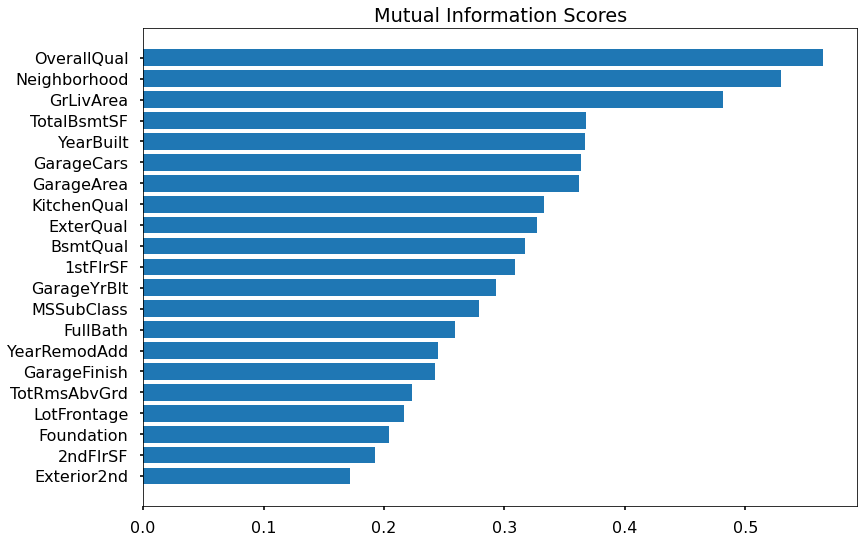

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure()
plot_mi_scores(mi_scores[:21])

Calculate the pearson correlation coefficent 

r = $\frac{\sum (x - \bar{x}) (y - \bar{y})}{ \sqrt{\sum (x - \bar{x})^2} \sqrt{\sum (y - \bar{y})^2} }$

amoung all the numerical features. We will deal with the categorical data in a bit, this will help us examine which features correlate strongly with the target variable so we can select them

<AxesSubplot:>

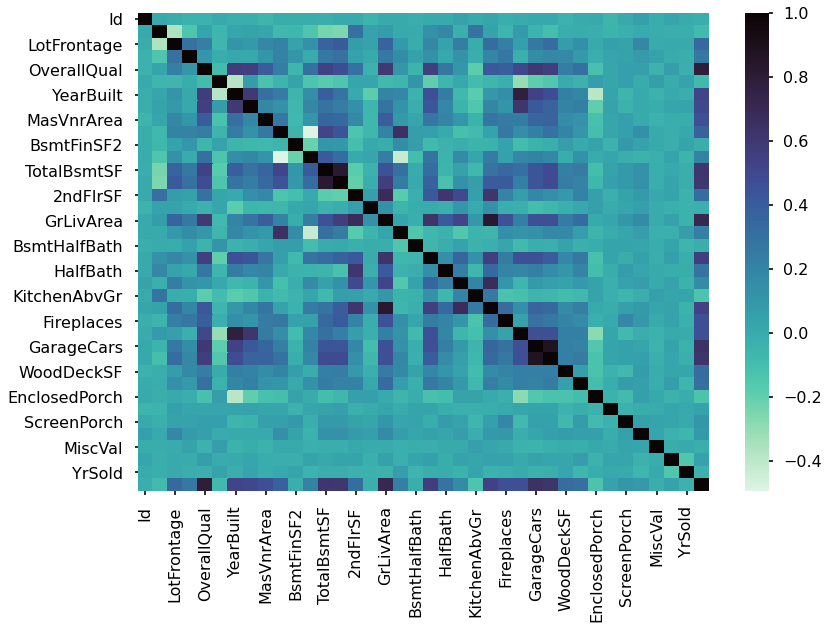

In [28]:
corr = pd.concat([X_num_imputed,y], axis=1).corr()
sns.heatmap(corr, annot=False, cmap='mako_r')

In [29]:
# this is like doing a sort on the salePrice column
cols = corr.nlargest(21, 'SalePrice')['SalePrice'].index

In [30]:
cols[1:]

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'GarageYrBlt', 'BsmtFinSF1', 'LotFrontage',
       'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea'],
      dtype='object')

In [31]:
mi_scores[:20].index

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageCars', 'GarageArea', 'KitchenQual', 'ExterQual', 'BsmtQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'FullBath', 'YearRemodAdd',
       'GarageFinish', 'TotRmsAbvGrd', 'LotFrontage', 'Foundation',
       '2ndFlrSF'],
      dtype='object')

Let's try a random forest with all the features first, then a random forest with the top ten features acording to their mutual information to see if there's a difference in performance.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# perform a gridsearch varying the number of trees and max depth
rfRS = GridSearchCV(
        RandomForestRegressor(),
        {"n_estimators":[500,1000,1500,2000],
        "max_depth":[1,2,3,4,5],
        },
        cv=3)
# grab the bestfit parameters
rfRS_result = rfRS.fit(X_train, y_train)
rfRS_best_params = rfRS_result.best_params_

In [33]:
## make a new random forest using the best fit parameters
best_rf = RandomForestRegressor(**rfRS_best_params)
best_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=1500)

In [34]:
# make some predictions and calculate the MAE
ypred = best_rf.predict(X_valid)
np.sqrt(np.square(y_valid - ypred)).mean()

20086.2146080906

In [59]:
# repeat the above process, but now using the top 10 features from our mutual information scores
rfRS = GridSearchCV(
        RandomForestRegressor(),
        {"n_estimators":[500,1000,1500,2000],
        "max_depth":[1,2,3,4,5],
        },
        cv=3)

rfRS_result = rfRS.fit(X_train.loc[:,['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual']], y_train)
rfRS_best_params = rfRS_result.best_params_
best_rf = RandomForestRegressor(**rfRS_best_params)
best_rf.fit(X_train.loc[:,['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual']],y_train)
ypred = best_rf.predict(X_valid.loc[:,['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual']])
np.sqrt(np.square(y_valid - ypred)).mean()

20378.614557590317

Pretty much the same performance. Cool, we can just keep a model the top 10 features according to their mutual information. 
Let's submit this to Kaggle and get a score

In [74]:
y_hat = best_rf.predict(X_test.loc[:,['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt',
       'GarageArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual']])
pd.DataFrame({"Id":t_test['Id'], "SalePrice":y_hat}).to_csv('HousingSubmissionRF.csv', index=False)

I get a score of 0.17974 on Kaggle. 

Let's set aside these numbers for the time being and keep them as a base line, Let's see how we can do using algorithms that will only be able to handel the numerical data

Let's examine the top 20 features according to their pearson correlation coefficent.

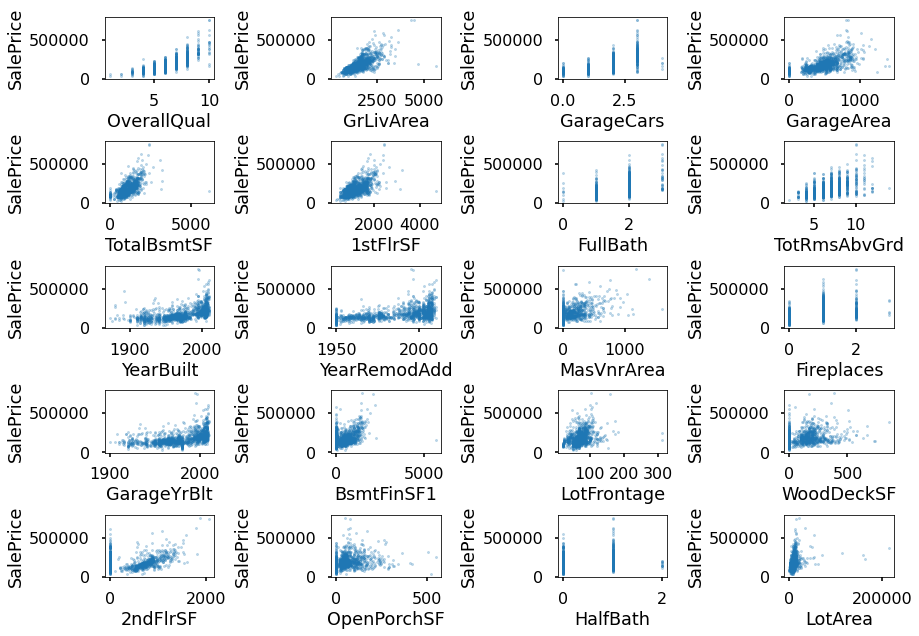

In [36]:
fig, ax = plt.subplots(ncols=4, nrows=5)

for i, a in zip(cols[1:],ax.flatten()):
    a.scatter(X[i], y,s=5, alpha=.3)
    a.set_xlabel(i)
    a.set_ylabel('SalePrice')
plt.tight_layout()

Try linear regression using the top 10 features accordng to their pearson correlation coefficent, then with all the features to see if there is a difference in the MAE

In [38]:
lin_reg = LinearRegression().fit(X_train_num, y_train_num)
ypred = lin_reg.predict(X_valid_num)
np.sqrt(np.square(y_valid_num - ypred)).mean()

23697.017354637097

In [50]:
from sklearn.linear_model import LinearRegression
features = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF',
           '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
lin_reg = LinearRegression().fit(X_train.loc[:,features], y_train)
ypred = lin_reg.predict(X_valid.loc[:,features])
np.sqrt(np.square(y_valid - ypred)).mean()

22844.17062062577

The performance is basically the same. Instead of playing a game where we see which number of features is the minimum one you need, lets just continue to use the top 10 features

Now lets try some other regression techniques, namely Ridge, Lasso, and KNN. Calculate the MAE for each algorithm

In [41]:
from sklearn.linear_model import Ridge
parameters = {'alpha':[.01,.1,1,2,3,4,5,6,7,8,9,10,20,50,70,100,200]}
#parameters = {'alpha':[.01,.1]}
reg = Ridge()
clf = GridSearchCV(reg, parameters)
res = clf.fit(X_train,y_train)
alpha_best = res.best_params_
ridge_reg = Ridge(**alpha_best).fit(X_train_num.loc[:,features],y_train_num)
ypred = ridge_reg.predict(X_valid_num.loc[:,features])
np.sqrt(np.square(y_valid_num - ypred)).mean()

25601.82494016487

In [43]:
from sklearn.linear_model import Lasso
parameters = {'alpha':[.001,.01,.1,1,2,3,4,5,6,7,8,9,10,20,50,70,100,200]}
#parameters = {'alpha':[.01,.1]}
reg = Lasso()
clf = GridSearchCV(reg, parameters)
res = clf.fit(X_train_num,y_train_num)
alpha_best = res.best_params_
lasso_reg = Lasso(**alpha_best).fit(X_train_num.loc[:,features],y_train_num)
ypred = lasso_reg.predict(X_valid_num.loc[:,features])
np.sqrt(np.square(y_valid_num - ypred)).mean()

25785.574690630543

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
parameters = {"n_neighbors":[5,6,7,8,9,10,15,20]}
reg = KNeighborsRegressor()
clf = GridSearchCV(reg, parameters)
res = clf.fit(X_train_num, y_train_num)
knn = KNeighborsRegressor(**res.best_params_).fit(X_train_num.loc[:,features], y_train_num)
ypred = knn.predict(X_valid_num.loc[:,features])
np.sqrt(np.square(y_valid_num - ypred)).mean()

29923.661643835618

Linear regression, Ridge, and Lasso regression all do about the same, slightly worse than the random forest, and K nearest neighboors performs the poorest. All of them are poorer than the random forest we fit. 

Now let's see if we can stack a few of our regression techniques together to make a blended model. In a blended model, the predictions of several ML algorithms are used to form a new set of training data. This gets fed to a meta model, which makes a final round of predictions. We will use a random forest regressor as the meta model

In [51]:
meta_X=[]
for algo in [lin_reg, ridge_reg, lasso_reg]:
    yhat = algo.predict(X_valid_num.loc[:,features])
    yhat = yhat.reshape(len(yhat), 1)
    # store prediction
    meta_X.append(yhat)

In [52]:
meta_X = np.hstack(meta_X)

In [53]:
meta_X.shape

(365, 3)

In [55]:
rf = RandomForestRegressor(n_estimators=1500, max_depth=5)
rf.fit(meta_X, y_valid_num)

RandomForestRegressor(max_depth=5, n_estimators=1500)

In [69]:
meta_X_test=[]
for algo in [lin_reg, ridge_reg, lasso_reg]:
    yhat = algo.predict(X_test.loc[:,features])
    yhat = yhat.reshape(len(yhat), 1)
    # store prediction
    meta_X_test.append(yhat)
meta_X_test = np.hstack(meta_X_test)

In [75]:
yhat = rf.predict(meta_X_test)
pd.DataFrame({"Id":t_test['Id'], "SalePrice":yhat}).to_csv('HousingSubmissionBlend.csv', index=False)

I got a score of 0.16373 on Kaggle with the blended model, an improvement of our regular Random Forest. Cool!